<a href="https://colab.research.google.com/github/OnlyourMiracle/MachineLearning/blob/master/Course/PythonMachineLearning/PythonMachineLerning_U12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
os.chdir('/content/drive/MyDrive/MLIA/Data/mnist')
os.getcwd()


!gzip t10k-images-idx3-ubyte.gz -d
!gzip t10k-labels-idx1-ubyte.gz -d
!gzip train-images-idx3-ubyte.gz -d
!gzip train-labels-idx1-ubyte.gz -d

gzip: t10k-images-idx3-ubyte.gz: No such file or directory
gzip: t10k-labels-idx1-ubyte.gz: No such file or directory
gzip: train-images-idx3-ubyte.gz: No such file or directory
gzip: train-labels-idx1-ubyte.gz: No such file or directory


In [ ]:
import os
import struct 
import numpy as np

def load_mnist(path, kind='train'):
  labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
  images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)

  with open(labels_path, 'rb') as lbpath:
    magic, n = struct.unpack('>II', lbpath.read(8))
    labels = np.fromfile(lbpath, dtype=np.uint8)

  with open(images_path, 'rb') as imgpath:
    magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
    images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
    images = ((images / 255.) - .5) * 2

  return images, labels

In [ ]:
x_train, y_train = load_mnist('', 'train')
x_test, y_test = load_mnist('', 't10k')

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


In [ ]:
np.savez_compressed('/content/drive/MyDrive/MLIA/Data/mnist/mnist_scaled.npz', x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)
import numpy as np 
mnist = np.load('/content/drive/MyDrive/MLIA/Data/mnist/mnist_scaled.npz')
mnist.files

['x_train', 'y_train', 'x_test', 'y_test']

In [ ]:
x_train, y_train, x_test, y_test = [mnist[f] for f in ['x_train', 'y_train', 'x_test', 'y_test']]
del mnist
x_train.shape

(60000, 784)

In [ ]:
import sys

class NeuralNetMLP(object):
  def __init__(self, n_hidden=30, l2=0., epochs=100, eta=0.001, shuffle=True, minibatch_size=1, seed=None):
    self.random = np.random.RandomState(seed)
    self.n_hidden = n_hidden
    self.epochs = epochs 
    self.l2 = l2
    self.eta = eta 
    self.shuffle = shuffle 
    self.minibatch_size = minibatch_size

  def _onehot(self, y, n_classes):
    onehot = np.zeros((n_classes, y.shape[0]))
    for idx, val in enumerate(y.astype(int)):
      onehot[val, idx] = 1. 
    return onehot.T 

  def _sigmoid(self, z):
    return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
  
  def _forward(self, x):
    z_h = np.dot(x, self.w_h) + self.b_h 
    a_h = self._sigmoid(z_h) 
    z_out = np.dot(a_h, self.w_out) + self.b_out
    a_out = self._sigmoid(z_out) 
    return z_h, a_h, z_out, a_out

  def _compute_cost(self, y_enc, output):
    L2_term = (self.l2 * (np.sum(self.w_h ** 2.) + np.sum(self.w_out ** 2.)))

    term1 = -y_enc * (np.log(output))
    term2 = (1. - y_enc) * np.log(1. - output)
    cost = np.sum(term1 - term2) + L2_term
    return cost 
  
  def predict(self, x):
    z_h, a_h, z_out, a_out = self._forward(x)
    y_pred = np.argmax(z_out, axis=1)
    return y_pred

  def fit(self, x_train, y_train, x_valid, y_valid):
    n_output = np.unique(y_train).shape[0]
    n_features = x_train.shape[1]

    self.b_h = np.zeros(self.n_hidden)
    self.w_h = self.random.normal(loc=0.0, scale=0.1, size=(n_features, self.n_hidden))

    self.b_out = np.zeros(n_output)
    self.w_out = self.random.normal(loc=0.0, scale=0.1, size=(self.n_hidden, n_output))

    epoch_strlen = len(str(self.epochs))
    self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

    y_train_enc = self._onehot(y_train, n_output)

    for i in range(self.epochs):
      indices = np.arange(x_train.shape[0])
      if self.shuffle:
        self.random.shuffle(indices)
      for start_idx in range(0, indices.shape[0] - self.minibatch_size + 1, self.minibatch_size):
        batch_idx = indices[start_idx:start_idx + self.minibatch_size]
        z_h, a_h, z_out, a_out = self._forward(x_train[batch_idx])

        sigma_out = a_out - y_train_enc[batch_idx]
        sigmoid_derivative_h = a_h * (1. - a_h)
        sigma_h = (np.dot(sigma_out, self.w_out.T) * sigmoid_derivative_h)
        grad_w_h = np.dot(x_train[batch_idx].T, sigma_h)
        grad_b_h = np.sum(sigma_h, axis=0)

        grad_w_out = np.dot(a_h.T, sigma_out)
        grad_b_out = np.sum(sigma_out, axis=0)

        delta_w_h = (grad_w_h + self.l2 * self.w_h)
        delta_b_h = grad_b_h
        self.w_h -= self.eta * delta_w_h
        self.b_h -= self.eta * delta_b_h 

        delta_w_out = (grad_w_out + self.l2 * self.w_out)
        delta_b_out = grad_b_out 
        self.w_out -= self.eta * delta_w_out 
        self.b_out -= self.eta * delta_b_out 

      z_h, a_h, z_out, a_out = self._forward(x_train)
      cost = self._compute_cost(y_enc=y_train_enc, output=a_out)
      y_train_pred = self.predict(x_train)
      y_valid_pred = self.predict(x_valid)

      train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float)/x_train.shape[0])
      valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) / x_valid.shape[0])

      sys.stderr.write('\r%0*d/%d | Cost: %.2f '
                '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                (epoch_strlen, i+1, self.epochs, cost,
                train_acc*100, valid_acc*100))
      sys.stderr.flush()

      self.eval_['cost'].append(cost)
      self.eval_['train_acc'].append(train_acc)
      self.eval_['valid_acc'].append(valid_acc)
    return self

In [ ]:
nn = NeuralNetMLP(n_hidden=100, l2=0.01, epochs=200, eta=0.0005, minibatch_size=100, shuffle=True, seed=1)

nn.fit(x_train=x_train[:55000], y_train=y_train[:55000], x_valid=x_train[55000:], y_valid=y_train[55000:])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
200/200 | Cost: 5065.78 | Train/Valid Acc.: 99.28%/97.98% 

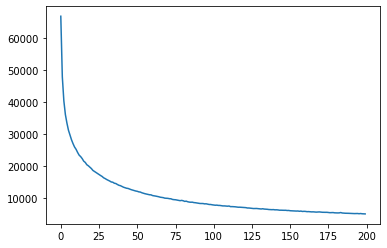

In [ ]:
import matplotlib.pyplot as plt 

plt.plot(range(nn.epochs), nn.eval_['cost'])

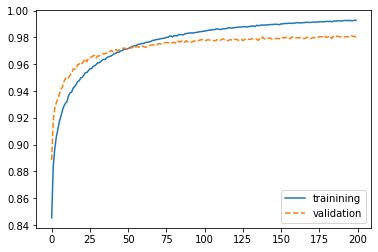

In [ ]:
plt.plot(range(nn.epochs), nn.eval_['train_acc'], label='trainining')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'], label='validation', linestyle='--')
plt.legend()

In [ ]:
y_test_pred = nn.predict(x_test)
acc = (np.sum(y_test == y_test_pred).astype(np.float)/x_test.shape[0])
print(acc*100)

97.54


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
